In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from os import walk
import time
import regex as re
import os
import glob
import tensorflow as tf
import warnings
import matplotlib
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

__GPU COnfiguration__

In [3]:
import warnings

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found")
else:
    print("Default GPU device: {}".format(tf.test.gpu_device_name()))
    
print("Num Devices Available: ", len(tf.config.experimental.list_physical_devices()))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU device: /device:GPU:0
Num Devices Available:  2
Num CPUs Available:  1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14727356659095606597
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909195470
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5645149393099628128
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


__Read HDF5 file__

In [4]:
def read_many_hdf5(num_images, file_path):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(file_path, "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

__Loss Accuracy Curve__

In [5]:
def loss_accuracy_curves(history):
    ############### printing accuracy and loss between the epoches #########
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label ="Validation")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("Accuracy.pdf", format="pdf")
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label ="Validation")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("Loss.pdf", format="pdf")
    plt.show()

# Preprocessing Images

__Ostu Binarisation__

In [6]:
def ostu_thd(XX):
    rnd_images = []
    for img in XX:
        #img = rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Otsu's thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        rnd_images.append(th2)
    test_images = np.array(rnd_images)
    
    return test_images

__Train and Test Split + Reshaping Data to adjust greyscal dimension__

In [7]:
from sklearn.model_selection import train_test_split

def pre_process(X, y):
    
    # test_size is the test size of the total dataset, random_state controls the shuffling of data. same state returns same data always.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=786, stratify=y) 
    print("Total training intences: " + str(len(y_train)))
    print("Train Data:" + str(np.unique(y_train, return_counts=True)))
    print("Total testing intences: " + str(len(y_test)))
    print("Test Data:" + str(np.unique(y_test, return_counts=True)))

    print("Before Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 190, 150, 1))
    X_test = X_test.reshape((X_test.shape[0], 190, 150, 1))
    print("After Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    
    # Convert the array to float32 as opposed to uint8
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    X_train /= 255
    X_test /=  255

    NUM_DIGITS = 2

    print("Before", y_train[0]) # The format of the labels before conversion

    y_train  = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

    print("After", y_train[0]) # The format of the labels after conversion

    y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)
    
    return X_train, X_test, y_train, y_test

__Final Model__

In [8]:
def final_model():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='tanh', input_shape=(190, 150,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(448, activation=tf.nn.tanh, input_shape=(28500,)))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=['accuracy'])

    print(model.summary())
    return model


__Final Model with regularisation__

In [9]:
def final_model_regularised():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='tanh', input_shape=(190, 150,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(448, activation=tf.nn.tanh, input_shape=(28500,), kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=['accuracy'])

    print(model.summary())
    return model


## Main Execution Body
### Final Model

Total X intences: (5135, 190, 150, 3)
Total y intences: 5135
Total Non porosity images: 2578
Total porosity images: 2557
X Shape after Ostu Binarisation: (5135, 190, 150)
Total training intences: 3594
Train Data:(array([0, 1], dtype=uint8), array([1804, 1790], dtype=int64))
Total testing intences: 1541
Test Data:(array([0, 1], dtype=uint8), array([774, 767], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3594, 190, 150)
(1541, 190, 150)
After Reshaping the shape of train and test dataset:
(3594, 190, 150, 1)
(1541, 190, 150, 1)
Before 1
After [0. 1.]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 150, 96)      960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 38, 96)       0         
 )                                                               
     

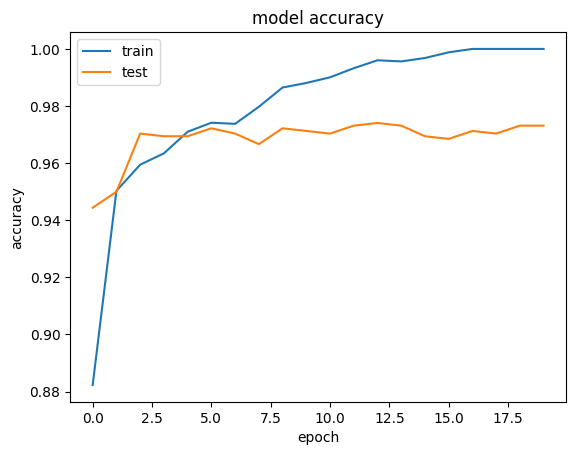

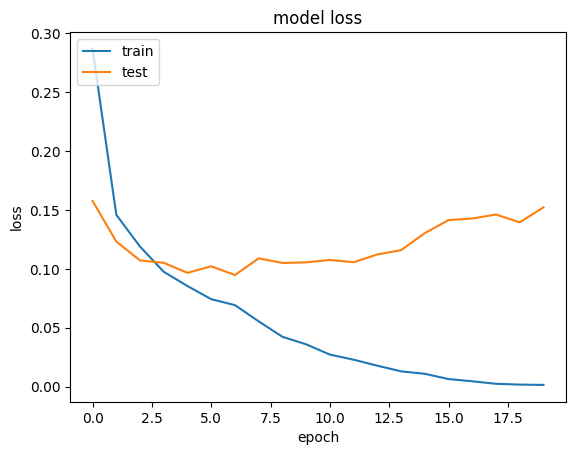

In [11]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

############ read Dataset
dir_file_path = "D:/UoH_PhD_Exp/Data/Data_HDF/Porosity_Balanced_Data.h5"
X, y = read_many_hdf5(0,dir_file_path)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Non porosity images: " + str(my_count[0]))
print("Total porosity images: " + str(my_count[1]))

############ Ostu Binarization
X = ostu_thd(X)
print("X Shape after Ostu Binarisation: " + str(X.shape))
############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model1 = final_model()
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history1 = model1.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_split=0.3)#, class_weight=my_class_weight)
print(history1)
########### Evaluate model
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy1))
print('Test loss: %.2f' % (loss1))
########## Classification Report
y_pred = model1.predict(X_test)
y_actual = np.argmax(y_test,axis=1)
print(y_actual[0:25])
y_pred = np.argmax(y_pred,axis=1)
print(y_pred[0:25])

print(classification_report(y_actual,y_pred))
print(confusion_matrix(y_actual,y_pred))
print(accuracy_score(y_actual,y_pred))

################# PLot Loss accuracy curves
loss_accuracy_curves(history1)

### Final Model Regularised

Total X intences: (5135, 190, 150, 3)
Total y intences: 5135
Total Non porosity images: 2578
Total porosity images: 2557
X Shape after Ostu Binarisation: (5135, 190, 150)
Total training intences: 3594
Train Data:(array([0, 1], dtype=uint8), array([1804, 1790], dtype=int64))
Total testing intences: 1541
Test Data:(array([0, 1], dtype=uint8), array([774, 767], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3594, 190, 150)
(1541, 190, 150)
After Reshaping the shape of train and test dataset:
(3594, 190, 150, 1)
(1541, 190, 150, 1)
Before 1
After [0. 1.]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 190, 150, 96)      960       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 38, 96)       0         
 2D)                                                             
   

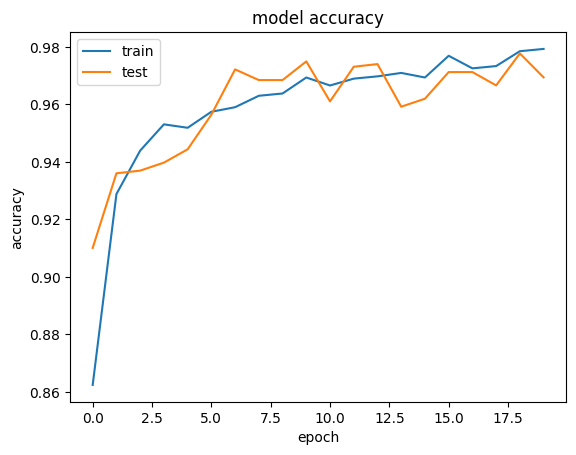

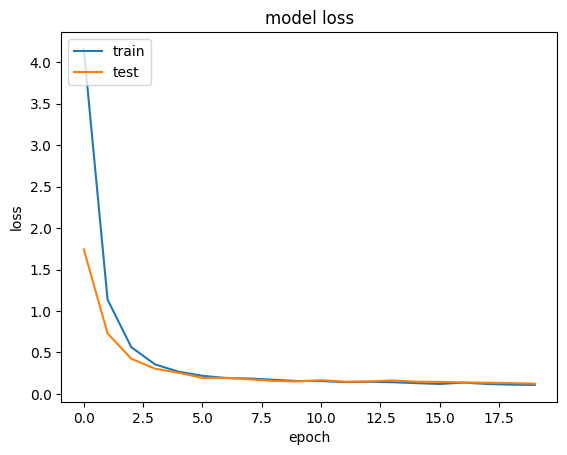

In [14]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import keras
############ read Dataset
dir_file_path = "D:/UoH_PhD_Exp/Data/Data_HDF/Porosity_Balanced_Data.h5"
X, y = read_many_hdf5(0,dir_file_path)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Non porosity images: " + str(my_count[0]))
print("Total porosity images: " + str(my_count[1]))

############ Ostu Binarization
X = ostu_thd(X)
print("X Shape after Ostu Binarisation: " + str(X.shape))
############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model1 = final_model_regularised()
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history1 = model1.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_split=0.3)#, class_weight=my_class_weight)
print(history1)
########### Evaluate model
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy1))
print('Test loss: %.2f' % (loss1))
########## Classification Report
y_pred = model1.predict(X_test)
y_actual = np.argmax(y_test,axis=1)
print(y_actual[0:25])
y_pred = np.argmax(y_pred,axis=1)
print(y_pred[0:25])

print(classification_report(y_actual,y_pred))
print(confusion_matrix(y_actual,y_pred))
print(accuracy_score(y_actual,y_pred))

################# PLot Loss accuracy curves
loss_accuracy_curves(history1)